# Time Evolution
Using what we learned from the effective Hamiltonian, it is now time to compute the density matrix. Recall that the density matrix (linearly mapped to a vector) absent any noise is given by:
$$
    \newcommand{ket}[1]{\left|#1\right\rangle}
    \newcommand{bra}[1]{\left\langle#1\right|}
    \vec{\rho}(t) = (R\otimes R)\left( \sum_{jk}e^{-i\omega_{jk}t}\ket{j}\bra{j}\otimes \ket{k}\bra{k} \right) (R^{-1}\otimes R^{-1})\vec{\rho}(0)
$$
with $R$ the eigenvector matrix and $\omega_{jk}$ the eigenvalues of the system.

## Flip Flop Qubit
Again, the Hamiltonian for the flip-flop qubit is:
$$
H_\textrm{ff} = \hbar \sum_m \omega_c^{(m)} a_m^\dagger a_m + \sum_i\sum_j E_{ij} \ket{j}_i\bra{j}_i + \sum_m\sum_i\frac{1}{2}g_c^{(m)}(a_m+a_m^\dagger)(1+Z_i)
$$
with the $m$ are all cavity modes (we'll be considering only a simgle mode for now so we can ignore the summation over $m$), $i$ are each flip-flop qubit, and $j$ are the states of each qubit.

$Z$ is the electron position and is defined as: 
$$
Z = \sum_{jk} z_{jk}\sigma_j\tau_j 
$$
$\omega_c$ is the cavity energy and $g_c$ is the photon-charge coupling strength. The eigenenergies up to second order in perturbation theory in the single qubit case are:
$$
        \begin{align}
            E_0 &= \frac{1}{2}(-\omega_0-\omega_B)-\frac{A}{8} \left(1-\cos \eta\right)-\frac{\Delta\omega_B}{4}\left(1+\cos \eta\right)-\frac{A^2}{16\omega_B}\left((1-\cos\eta)^2+\sin^2\eta(\frac{\omega_B}{4\omega_0}+\frac{\omega_B}{\omega_0+\omega_B}-\frac{\omega_B\Delta\omega_B}{A\omega_0}+\frac{\omega_B\Delta\omega_B^2}{A^2\omega_0})\right)\\
            E_1 &= \frac{1}{2}(-\omega_0+\omega_B)-\frac{A}{8} \left(1-\cos \eta\right)+\frac{\Delta\omega_B}{4}\left(1+\cos \eta\right)-\frac{A^2}{16\omega_B}\left(-(1-\cos\eta)^2+\sin^2\eta(\frac{\omega_B}{4\omega_0}+\frac{\omega_B}{\omega_0-\omega_B}+\frac{\omega_B\Delta\omega_B}{A\omega_0}+\frac{\omega_B\Delta\omega_B^2}{A^2\omega_0})\right) \\
            E_2 &= \frac{1}{2}( \omega_0-\omega_B)-\frac{A}{8} \left(1+\cos \eta\right)-\frac{\Delta\omega_B}{4}\left(1-\cos \eta\right)-\frac{A^2}{16\omega_B}\left((1+\cos\eta)^2+\sin^2\eta(-\frac{\omega_B}{4\omega_0}-\frac{\omega_B}{\omega_0-\omega_B}+\frac{\omega_B\Delta\omega_B}{A\omega_0}-\frac{\omega_B\Delta\omega_B^2}{A^2\omega_0})\right) \\
            E_3 &= \frac{1}{2}( \omega_0+\omega_B)-\frac{A}{8} \left(1+\cos \eta\right)+\frac{\Delta\omega_B}{4}\left(1-\cos \eta\right)-\frac{A^2}{16\omega_B}\left(-(1+\cos\eta)^2+\sin^2\eta(-\frac{\omega_B}{4\omega_0}-\frac{\omega_B}{\omega_0+\omega_B}-\frac{\omega_B\Delta\omega_B}{A\omega_0}-\frac{\omega_B\Delta\omega_B^2}{A^2\omega_0})\right)
        \end{align}
$$
and the coefficients of $Z$ are
$$
        \begin{align}
            z_{01} &= -A\omega_0\Delta\omega_B\cos\eta\sin^2\eta/4\omega_B(\omega_0^2-\omega_B^2) \\
            z_{03} &= A^2\omega_0^3\cos\eta\sin^2\eta/4\omega_B(\omega_0^2-\omega_B^2)^2 \\
            z_{10} &= \sin\eta + A\cos\eta\sin\eta/4\omega_0 \\
            z_{11} &= -A\omega_0\cos\eta\sin\eta/2(\omega_0^2-\omega_B^2) \\
            z_{13} &= -\Delta\omega_B\cos\eta\sin\eta/2\omega_0 \\
            z_{22} &= -A\omega_0^2\cos\eta\sin\eta/2\omega_B(\omega_0^2-\omega_B^2) \\
            z_{30} &= \cos\eta - A\sin^2\eta/4\omega_0 \\
            z_{31} &= A\omega_0\sin^2\eta/2(\omega_0^2-\omega_B^2) \\
            z_{33} &= \Delta\omega_B\sin^2\eta/2\omega_0 
        \end{align}
$$

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import datetime

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Import System functions and Hamiltonians
from Scripts.DensityMatrix_TimeEvolution import *
from Scripts.plotTimeEvolution import *
from Scripts.Noise.Pink import *
from Scripts.Systems.FlipFlop import *

We also don't care so much about the photon number so we should trace out that degree of freedom.
$$
    \rho_{\textrm{ff}}(t) = \textrm{Tr}_c(\rho(t))
$$

In [26]:
Nq = 4 # Number of states per qubit
Nm = 1 # Number of cavity modes

# You can play around with these
Nd = 2 # Number of donor qubits
Np = 1 # Maximum number of photons per mode
Nn = 2 # Nd

withNoise = True if (Nn > 0) else False
#                    IX, IZ, XI, XX, XZ, YY, ZI, ZX, ZZ
approxInteraction = [ 0,  0,  1,  0,  0,  0,  0,  1,  0]
approxNoise =       [ 0,  0,  0,  1,  0,  1,  0,  0,  0]

# Initialize cavity( to va)cuum state
initial_cavity_state_single_mode = np.zeros(((Np+1),1))
initial_cavity_state_single_mode[0,:] = 1
initial_cavity_state_multi_modes = [initial_cavity_state_single_mode] * Nm
initial_cavity_state = kron(initial_cavity_state_multi_modes)

# Initialize flip-flop to be |0...0>|1>
initial_flipflop_state = np.zeros(((4)**Nd,1))
initial_flipflop_state[1,:] = 1

# print(initial_cavity_state.transpose()# )
# print(initial_flipflop_state.transpose# ())

# Build total state
initial_total_state = np.kron(initial_cavity_state,initial_flipflop_state)

# Build parameter dicts
parameters_qubits = []
for _ in range(Nd):
    parameters_qubits.append({'Vt':11.4, 'wB':11.15, 'eps':1.15})
parameters_cavity = []
for _ in range(Nm):
    parameters_cavity.append({'wc': 10 , 'gc':0.01})
parameters_noise = []
for i in range(Nn):
    parameters_noise.append({'type':Pink(wl=2.0*np.pi*1e-15,wh=2.0*np.pi*1e3),'wn':0.323,'effected_donors':np.eye(1,Nd,i).flatten()})
# Create System Hamiltonians
system = FlipFlopSystem({
                        'Nm': Nm,
                        'Np': Np,
                        'Nd': Nd,
                        'Nn': Nn,
                        'parameters_cavity': parameters_cavity,
                        'parameters_qubits': parameters_qubits,
                        'parameters_noise': parameters_noise
                        })

flipflopenergies = np.diag(system.getQubitHamiltonian())
w01 = flipflopenergies[1]-flipflopenergies[0]
for mode in range(Nm):
    system.parameters_cavity[mode]['wc']=w01

# Compute 
N_t =500
T_Max =100000
t, rho =  computeDensityMatrix(system, initial_total_state, T_Max, N_t, withNoise=withNoise, dephaseOnly=True, approxInteraction=approxInteraction,approxNoise=approxNoise)
# print(t.shape)
# print(rho.shape)
rho_cav, rho_ff = partialTrace(rho, (Np+1)**Nm, Nq**Nd)
# print(rho_cav.shape)
# print(rho_ff.shape)# # # 

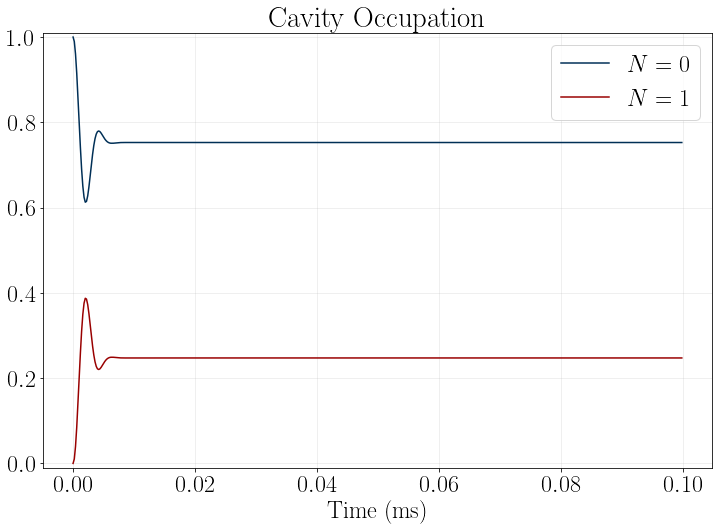

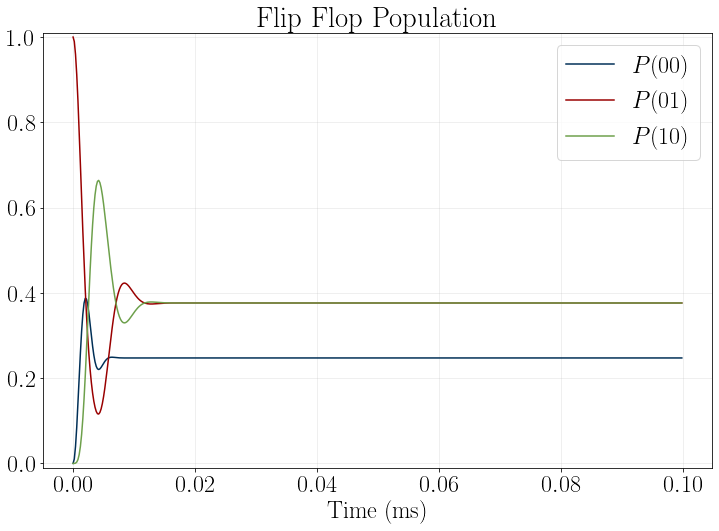

In [28]:
# Plot and save
timeString = datetime.datetime.now().strftime('%m%d%H%M%S')
filename = plotCavityPopulation(t, rho_cav, name = f"{Nd}q{Np}p_CavityOccupation_{timeString}")
saveParameters(filename, withNoise, parameters_qubits,parameters_cavity, parameters_noise,approxInteraction=approxInteraction,approxNoise=approxNoise)
filename = plotFlipFlopPopulation(t, rho_ff, Nd, states=[],name = f"{Nd}q{Np}p_FlipFlopPopulation_{timeString}")
saveParameters(filename, withNoise,parameters_qubits,parameters_cavity, parameters_noise,approxInteraction=approxInteraction,approxNoise=approxNoise)

Comparing the cavity occupation plots for different values of the cavity energy, $\omega_c$, we can see that for larger cavity energies, we can neglect values of $N_p>1$ if $g_c$ is sufficiently small since the photon in the singly occupied state is quickly annihilated to return back to the vaccum state.

# Time Evolution with Noise

Now we introduce classical noise to the system. We model the Hamiltonian as:
$$
    H(t) = H_\textrm{ff} + \sum_i f_i(t)h_i
$$
For our system in particular, we model the noise as fluctuations in the applied electric field.
$$
    h_i = \frac{1}{2}\omega_iZ_i
$$
With this in mind, the time evolution of the density matrix is now given by:
$$
\vec{\rho}(t) = \sum_{jk}e^{-i\omega_{jk}t}(R\otimes R)(\ket{j}\bra{j}\otimes\ket{k}\bra{k})e^{-\sum_iK_i(t)}(R^{-1}\otimes R^{-1})\vec{\rho}(0)
$$
with $K_i(t)$ giving us the decoherence due to the noise and is given by:
$$
K_i(t) =\sum_{abc}(h_{i,ab}h_{i,bc}J_i(t,\omega_{ba},\omega_{cb})\ket{a}\bra{c}\otimes 1+h_{i,ba}h_{i,cb}J_i(t,\omega_{ab},\omega_{bc}) 1\otimes \ket{a}\bra{c})-\sum_{abcd}h_{i,ac}h_{i,db} (J_i(t,\omega_{ca},\omega_{db})+J_i(t,\omega_{db},\omega_{ca})) \ket{a}\bra{c}\otimes \ket{b}\bra{d}
$$
If we consider only dephasing and neglect all other terms, $K$ can be simplified to
$$
    K_i(t) = J_i(t,0,0)\sum_{jk}\Gamma_{ijk}^2(\ket{j}\bra{j}\otimes\ket{k}\bra{k})
$$
where $\hbar\Gamma_{ijk} = \bra{j}R^{-1}h_iR\ket{j}-\bra{k}R^{-1}h_iR\ket{k}$ is the decoherence rate for that particular matrix element. The density matrix is then simply:
$$
\vec{\rho}(t) = \sum_{jk}e^{-i\omega_{jk}t - \sum_i J_i(t,0,0)\Gamma_{ijk}^2}(R\otimes R)(\ket{j}\bra{j}\otimes\ket{k}\bra{k})(R^{-1}\otimes R^{-1})\vec{\rho}(0)
$$